In [82]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
import numpy as np

print("TensorFlow version is: {}".format(tf.__version__))
print("Eager execution is: {}".format(tf.executing_eagerly()))
print("Keras version is: {}".format(tf.keras.__version__))

TensorFlow version is: 2.2.0
Eager execution is: True
Keras version is: 2.3.0-tf


# load model

In [88]:
!pwd


/Users/ankit/Documents/code/iOS/learn/CVRecorder/converters


In [89]:
# yolo_model = load_model('yolov4-608')
yolo_model = load_model('yolov4-608_1stJun')

In [90]:
yolo_model.outputs[0].shape

TensorShape([1, None, 84])

# read labels

In [91]:
def read_labels(labels_path):
    with open(labels_path) as f:
        labels = f.readlines()
    labels = [c.strip() for c in labels]
    return labels

In [92]:
labels = read_labels('coco.txt')
labels[:5]

['person', 'bicycle', 'car', 'motorbike', 'aeroplane']

# load image

In [93]:
from PIL import Image
def load_local_and_scale_image(image_path, shape):
    image = Image.open(image_path)
    return image.resize(shape)

In [94]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, interpolation = 'bilinear', target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0

    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    
    return image, width, height

In [95]:
# Pre-process the image
input_w, input_h = 608, 608
photo_filename = '/Users/ankit/Documents/code/iOS/learn/CVRecorder/converters/persons_1.jpeg'
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
print("image initial size: ", image_w, image_h)
print("input image",image.shape)

image initial size:  2000 1333
input image (1, 608, 608, 3)


# prediction

In [96]:
yhat = yolo_model.predict(image)
print(f'y hat shape = {yhat.shape}')
print("output:",[a.shape for a in yhat])

y hat shape = (1, 43, 84)
output: [(43, 84)]


# draw predictions

In [97]:
import colorsys
import random

def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] ), int(x[1] ), int(x[2] )), colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    return colors

In [98]:
def softmax_2d(x, axis=1):
    x_max = np.max(x, axis=axis)[:, np.newaxis]
    e_x = np.exp(x - x_max)
    x_sum = np.sum(e_x, axis=axis)[:, np.newaxis]    
    return e_x / x_sum

In [99]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle

def draw_bbs(file_name, preds):
    boxes = yhat[0][..., :4]
    pred_conf = yhat[0][..., 4:]
#     pred_conf = softmax_2d(pred_conf)
    print(f'boxes shape = {boxes.shape}')
    print(f'pred_conf shape = {pred_conf.shape}')
    print('------iteration completed------')
    print(boxes.shape)  
    print('start drawing boxes')
    data = pyplot.imread(file_name)
    ax = pyplot.gca()
    colors = generate_colors(labels)
    for i in range(boxes.shape[0]):
        box = boxes[i]
        class_id = np.argmax(pred_conf[i])
        score = pred_conf[i][class_id]
        y1, x1, y2, x2 = box[0], box[1], box[2], box[3]
        width, height = x2 - x1, y2 - y1
        rect = Rectangle(
            (x1 * image_w, y1 * image_h),
            width * image_w,
            height * image_h,
            fill=False,
            color=colors[class_id]
        )
        ax.add_patch(rect)
        label = "%s (%.3f)" % (labels[class_id], score*100)
        pyplot.text(
            x1* image_w,
            y1* image_h,
            label, 
            color= 'white'
        )
    # plot the image
    print('end drawing boxes')
    
    
    pyplot.imshow(data)
    pyplot.show()

boxes shape = (43, 4)
pred_conf shape = (43, 80)
------iteration completed------
(43, 4)
start drawing boxes
end drawing boxes


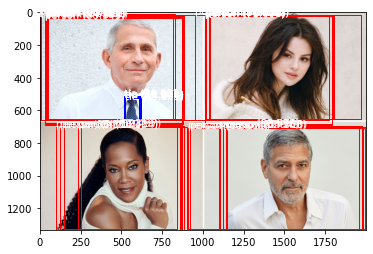

In [100]:
draw_bbs(photo_filename, yhat)

# load core ml model and coreml predictions

In [20]:
import coremltools as ct
yolo_coreml_model = ct.models.MLModel('yolov3Coreml_tiny_quantized_29thMay2022.mlmodel')

In [21]:
print(yolo_coreml_model)

input {
  name: "input_1"
  type {
    imageType {
      width: 608
      height: 608
      colorSpace: RGB
      imageSizeRange {
        widthRange {
          lowerBound: 608
          upperBound: 608
        }
        heightRange {
          lowerBound: 608
          upperBound: 608
        }
      }
    }
  }
}
output {
  name: "Identity"
  type {
    multiArrayType {
      dataType: FLOAT32
    }
  }
}
metadata {
  userDefined {
    key: "com.github.apple.coremltools.source"
    value: "tensorflow==2.2.0"
  }
  userDefined {
    key: "com.github.apple.coremltools.version"
    value: "4.0b3"
  }
}



In [22]:
INPUT_NODE = 'input_1'
OUTPUT_NODE = 'Identity'
print(f'{INPUT_NODE} -- {OUTPUT_NODE}')

input_1 -- Identity


In [23]:
print(image[0].shape)

(608, 608, 3)


In [24]:
test_image = load_local_and_scale_image(photo_filename, (608, 608)) 
preds_tiny_quantized = yolo_coreml_model.predict(data={INPUT_NODE: test_image})[OUTPUT_NODE]
print(preds_tiny_quantized.shape)

(1, 11, 84)


boxes shape = (43, 4)
pred_conf shape = (43, 80)
------iteration completed------
(43, 4)
start drawing boxes
end drawing boxes


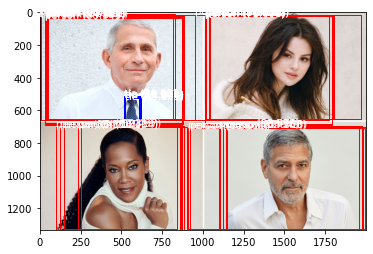

In [25]:
draw_bbs(photo_filename, preds_tiny_quantized)

# convert output layer of model

In [59]:
formated_yolo_coreml_model = ct.models.MLModel('yolov3Coreml_tiny_quantized_29thMay2022.mlmodel')
spec = formated_yolo_coreml_model.get_spec()

In [60]:
spec.description

input {
  name: "input_1"
  type {
    imageType {
      width: 608
      height: 608
      colorSpace: RGB
      imageSizeRange {
        widthRange {
          lowerBound: 608
          upperBound: 608
        }
        heightRange {
          lowerBound: 608
          upperBound: 608
        }
      }
    }
  }
}
output {
  name: "Identity"
  type {
    multiArrayType {
      dataType: FLOAT32
    }
  }
}
metadata {
  userDefined {
    key: "com.github.apple.coremltools.source"
    value: "tensorflow==2.2.0"
  }
  userDefined {
    key: "com.github.apple.coremltools.version"
    value: "4.0b3"
  }
}

In [61]:
output_ma_type = spec.description.output[0].type.multiArrayType
output_ma_type.shapeRange.sizeRanges.add()
output_ma_type.shapeRange.sizeRanges[0].lowerBound = 1
output_ma_type.shapeRange.sizeRanges[0].upperBound = 1

output_ma_type.shapeRange.sizeRanges.add()
output_ma_type.shapeRange.sizeRanges[1].lowerBound = 0
output_ma_type.shapeRange.sizeRanges[1].upperBound = -1

output_ma_type.shapeRange.sizeRanges.add()
output_ma_type.shapeRange.sizeRanges[2].lowerBound = 84
output_ma_type.shapeRange.sizeRanges[2].upperBound = 84
output_ma_type

dataType: FLOAT32
shapeRange {
  sizeRanges {
    lowerBound: 1
    upperBound: 1
  }
  sizeRanges {
    upperBound: -1
  }
  sizeRanges {
    lowerBound: 84
    upperBound: 84
  }
}

In [62]:
test_builder = ct.models.neural_network.NeuralNetworkBuilder(spec= spec)

In [63]:
test_builder.spec.description

input {
  name: "input_1"
  type {
    imageType {
      width: 608
      height: 608
      colorSpace: RGB
      imageSizeRange {
        widthRange {
          lowerBound: 608
          upperBound: 608
        }
        heightRange {
          lowerBound: 608
          upperBound: 608
        }
      }
    }
  }
}
output {
  name: "Identity"
  type {
    multiArrayType {
      dataType: FLOAT32
      shapeRange {
        sizeRanges {
          lowerBound: 1
          upperBound: 1
        }
        sizeRanges {
          upperBound: -1
        }
        sizeRanges {
          lowerBound: 84
          upperBound: 84
        }
      }
    }
  }
}
metadata {
  userDefined {
    key: "com.github.apple.coremltools.source"
    value: "tensorflow==2.2.0"
  }
  userDefined {
    key: "com.github.apple.coremltools.version"
    value: "4.0b3"
  }
}

In [64]:
converted_yolo_model = ct.models.MLModel(test_builder.spec)

In [65]:
print(converted_yolo_model)

input {
  name: "input_1"
  type {
    imageType {
      width: 608
      height: 608
      colorSpace: RGB
      imageSizeRange {
        widthRange {
          lowerBound: 608
          upperBound: 608
        }
        heightRange {
          lowerBound: 608
          upperBound: 608
        }
      }
    }
  }
}
output {
  name: "Identity"
  type {
    multiArrayType {
      dataType: FLOAT32
      shapeRange {
        sizeRanges {
          lowerBound: 1
          upperBound: 1
        }
        sizeRanges {
          upperBound: -1
        }
        sizeRanges {
          lowerBound: 84
          upperBound: 84
        }
      }
    }
  }
}
metadata {
  userDefined {
    key: "com.github.apple.coremltools.source"
    value: "tensorflow==2.2.0"
  }
  userDefined {
    key: "com.github.apple.coremltools.version"
    value: "4.0b3"
  }
}



In [66]:
test_image = load_local_and_scale_image(photo_filename, (608, 608)) 
preds_conerted_tiny_quantized = converted_yolo_model.predict(data={INPUT_NODE: test_image})[OUTPUT_NODE]
print(preds_conerted_tiny_quantized.shape)

(1, 11, 84)


boxes shape = (43, 4)
pred_conf shape = (43, 80)
------iteration completed------
(43, 4)
start drawing boxes
end drawing boxes


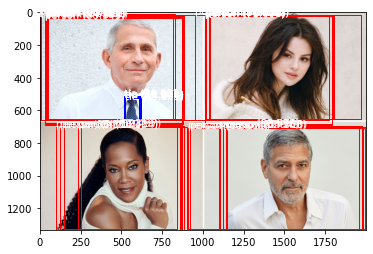

In [67]:
draw_bbs(photo_filename, preds_tiny_quantized)

In [81]:
converted_yolo_model.save('yolov3Coreml_converted_tiny_quantized_29thMay2022.mlmodel')

# integrate with decoder

In [101]:
from coremltools.models.neural_network import datatypes, NeuralNetworkBuilder

input_features = [ (INPUT_NODE, datatypes.Array(1,1,1))]
output_features = [ 'scores', 'box' ]
pipeline = ct.models.pipeline.Pipeline(input_features, output_features)
pipeline.spec.specificationVersion = 3



In [102]:
decoder_model = ct.models.MLModel('decoder.mlmodel')

In [70]:
pipeline.add_model(converted_yolo_model)

In [71]:
pipeline.add_model(decoder_model)

In [72]:
pipeline.spec.description.input[0].ParseFromString(converted_yolo_model._spec.description.input[0].SerializeToString())

40

In [73]:
pipeline.spec.description.output[0].ParseFromString(decoder_model._spec.description.output[0].SerializeToString())
pipeline.spec.description.output[1].ParseFromString(decoder_model._spec.description.output[1].SerializeToString())

42

In [74]:
pipeline.spec.description

input {
  name: "input_1"
  type {
    imageType {
      width: 608
      height: 608
      colorSpace: RGB
      imageSizeRange {
        widthRange {
          lowerBound: 608
          upperBound: 608
        }
        heightRange {
          lowerBound: 608
          upperBound: 608
        }
      }
    }
  }
}
output {
  name: "box"
  type {
    multiArrayType {
      shape: 0
      shape: 4
      dataType: DOUBLE
      shapeRange {
        sizeRanges {
          upperBound: -1
        }
        sizeRanges {
          lowerBound: 4
          upperBound: 4
        }
      }
    }
  }
}
output {
  name: "scores"
  type {
    multiArrayType {
      shape: 0
      shape: 80
      dataType: DOUBLE
      shapeRange {
        sizeRanges {
          upperBound: -1
        }
        sizeRanges {
          lowerBound: 80
          upperBound: 80
        }
      }
    }
  }
}

In [75]:
model_pipeline = ct.models.MLModel(pipeline.spec)

In [76]:
INPUT_NODE

'input_1'

In [80]:
test_image.size

(608, 608)

In [77]:
preds_pipeline = model_pipeline.predict(data={INPUT_NODE: test_image})
print(preds_tiny_quantized.shape)

RuntimeError: Error compiling model: "Error reading protobuf spec. validator error: Input MLMultiArray to neural networks must have at least 1 dimension.".